In [1]:
import json
import xml.etree.ElementTree as ET
from pathlib import Path

input_path = '/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/metadata/'
simulation_setup = "lowCongestion_5minDemand"

config = json.load(open(input_path + "/config.json"))
config["NETWORK"] = Path(config["NETWORK"])
config["SUMO"] = Path(config["SUMO"])
# [CO] updated simulation setup to use OD scenario #4: 42-dimensional  + low congestion.
#sim_setup = json.load(open(input_path + "simulation_setups_co_gt.json"))
sim_setup = json.load(open(input_path + f"simulation_setups_{simulation_setup}.json"))


In [2]:
# excluding warmup period of 15min
# so you need to simulate for at least 15min now. 
warm_up_sec = 15*60 # duration in seconds

# duration, in seconds, of each edge simulation output statistics
# this value should be consistent with what is defined in additional.add.xml
edge_stats_freq = 300

In [3]:
# %load /Users/rodrse/Downloads/calibrate_ods_carolina/notebooks/carolina/simulator_functions/helpers_sumo.py
## Main simulator function
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import torch

from pandas import DataFrame
from pathlib import Path


def run_sumo(config, sim_setup, prefix_input, prefix_output):
    od2trips_cmd = (
        #f"od2trips --no-step-log  --spread.uniform "
        f"od2trips  --spread.uniform "
        #Loads TAZ (districts)
        f"--taz-files {config['NETWORK']}/{sim_setup['taz']} " 
        # Loads O/D-matrix in tazRelation format fromFILE(s)
        f"--tazrelation-files {config['NETWORK']}/{sim_setup[f'{prefix_input}_od']} "
        # Writes trip definitions into FILE
        f"-o {config['NETWORK']}/{prefix_output}_{sim_setup['prefix_sim_run']}_od_trips.trips.xml " 
    )

    # Run SUMO to generate outputs
    sumo_run = (
        # Prefix which is applied to all output files. 
        f"sumo --output-prefix {prefix_output}_{sim_setup['prefix_sim_run']}_ " 
        # Do not check whether routes are connected
        f"--ignore-route-errors=true "
        # Load road network description from FILE
        f"--net-file={config['NETWORK']/sim_setup['net']} "
        # Load routes descriptions from FILE(s)
        f"--routes={config['NETWORK']}/{prefix_output}_{sim_setup['prefix_sim_run']}_od_trips.trips.xml "
        #  -b Defines the begin time in seconds; The simulation starts at this time
        # -e Defines the end time in seconds; The simulation ends at this time
        f"-b {sim_setup['start_sim_sec']} -e {sim_setup['end_sim_sec']} "
        # Load further descriptions from FILE(s)
        f"--additional-files {config['NETWORK']/sim_setup['add']} "
        f"--duration-log.statistics "
        f"--xml-validation never "
        # Save single vehicle route info into FILE
        f"--vehroutes {config['NETWORK']}/routes.vehroutes.xml "
        f"--verbose "
        # Disables output of warnings
        f"--no-warnings "
        # Faster simulation (i.e. less detailed)
        f"--mesosim true "
    
    )
        # f"--seed {seed}"

    try:
        print(od2trips_cmd)
        os.system(od2trips_cmd)
    except:
        print("Unable to create trips file")
    else:
        print("###### Running SUMO #######")
        print(sumo_run)
        os.system(sumo_run)


def parse_loop_data_xml_to_pandas(config: dict,loop_file: dict) -> DataFrame: 
    """Read the Loop Detectors Data: Each SUMO run produces a file with the
    traffic counts. This function reads the corresponding traffic counts file
    averages across simulation replications
    
    """

    output_file =(config["NETWORK"] / "loopOutputs.csv")
    ## See output explanation:
    # https://sumo.dlr.de/docs/Simulation/Output/Lane-_or_Edge-based_Traffic_Measures.html#generated_output

    data2csv = (
        f"python {config['SUMO']}/tools/xml/xml2csv.py "
        f"{loop_file} "
        f"-o {output_file}"
        )
    
    os.system(data2csv)
    
    df_trips = pd.read_csv(output_file, sep=";", header=0)

    # edge flow in vehicles per hour
    ## edge speed is given in m/s
    ## edge_density is given in no. of vehicles/km

    df_trips['interval_nVehContrib'] = df_trips['edge_arrived'] + df_trips['edge_left']
    #df_trips['interval_nVehContrib'] = 3.6*df_trips['edge_speed']*df_trips['edge_density']


    #df_trips['EdgeID'] = df_trips['edge_id']

    # edge speed is given in m/s
    # computed only for edges that have departed flow
    df_trips['interval_harmonicMeanSpeed'] = df_trips[df_trips['interval_nVehContrib']>0]['edge_speed']
    
    # exclude warm-up period
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]

    # aggregate the rest of the time intervals
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]
    df_agg = df_trips.groupby(by=['edge_id'], as_index=False).agg(
        {'interval_nVehContrib':np.sum, 'interval_harmonicMeanSpeed':np.mean})


    return df_agg, df_trips



def compute_nrmse_counts_one_edge(df_true, df_simulated,GT_edge_id):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    # only consider GT_edge_id of interest
    df1 = df1[df1['edge_id']==GT_edge_id]

    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN


def compute_nrmse_counts_all_edges(df_true, df_simulated):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN



def generate_od_xml(x, config, sim_setup):

    init_od_path = f"{config['NETWORK']}/{sim_setup['init_od']}"

    if Path(init_od_path).is_file():
        print("Reading:",init_od_path)
        tree = ET.parse(init_od_path)
        root = tree.getroot()

        for i,x in enumerate(x):
            root[0][i].attrib["count"] = str(np.round(x,4))
            
    file_name = f"{config['NETWORK']}/{sim_setup['current_od']}"
    print('Saving: '+file_name)
    tree.write(file_name)
## Find upper and lower bounds
import pandas as pd

def transform_od_xml_to_pandas(file_path_xml):

    tree = ET.parse(file_path_xml)
    root = tree.getroot()

    od_mat = []
    for taz_elem in root.iter('tazRelation'):
        od_mat.append([taz_elem.get('from'), taz_elem.get('to'), int(taz_elem.get('count'))])
    
    df_od = pd.DataFrame(od_mat, columns=['tazFrom', 'tazTo', 'tazCount'])

    return df_od


In [22]:
file_path_xml = str(config['NETWORK']) + "/" + sim_setup['gt_od']
df_gt = transform_od_xml_to_pandas(file_path_xml)

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double


In [23]:
dim_od = df_gt.shape[0]

In [24]:
### Obtain ground-truth value
loop_stats_df_gt, _ = parse_loop_data_xml_to_pandas(
    config,
    loop_file = f"/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/gt_{sim_setup['prefix_sim_run']}_edge_data_SFO.xml"
)


In [25]:
prefix_input = "current"
prefix_output = "current"
loop_file = f"/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/{prefix_output}_{sim_setup['prefix_sim_run']}_edge_data_SFO.xml"


### Run loop

In [20]:
NITER = 20
i = NITER
a = 1-1/((NITER - i) + 1)


bounds = torch.tensor([
    [ df_gt[ 'tazCount'] - a for _ in range(dim_od)],
    [ df_gt[ 'tazCount'] + a for _ in range(dim_od)]
], device=device, dtype=dtype) 

bounds

tensor([[[1., 1., 1.,  ..., 3., 1., 2.],
         [1., 1., 1.,  ..., 3., 1., 2.],
         [1., 1., 1.,  ..., 3., 1., 2.],
         ...,
         [1., 1., 1.,  ..., 3., 1., 2.],
         [1., 1., 1.,  ..., 3., 1., 2.],
         [1., 1., 1.,  ..., 3., 1., 2.]],

        [[1., 1., 1.,  ..., 3., 1., 2.],
         [1., 1., 1.,  ..., 3., 1., 2.],
         [1., 1., 1.,  ..., 3., 1., 2.],
         ...,
         [1., 1., 1.,  ..., 3., 1., 2.],
         [1., 1., 1.,  ..., 3., 1., 2.],
         [1., 1., 1.,  ..., 3., 1., 2.]]], dtype=torch.float64)

In [26]:
# Sample according to Sobol
from torch.quasirandom import SobolEngine
from botorch.utils.transforms import unnormalize

n0 = 1
sobol = SobolEngine(dim_od, scramble=True)

a = 1-1/((NITER - i) + 1)


bounds = torch.tensor([
    [ df_gt[ 'tazCount'] - a for _ in range(dim_od)],
    [ df_gt[ 'tazCount'] + a for _ in range(dim_od)]
], device=device, dtype=dtype) 

x_0 = sobol.draw(n0).to(dtype=dtype)

# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)
train_X0

tensor([[1., 1., 1.,  ..., 3., 1., 2.],
        [1., 1., 1.,  ..., 3., 1., 2.],
        [1., 1., 1.,  ..., 3., 1., 2.],
        ...,
        [1., 1., 1.,  ..., 3., 1., 2.],
        [1., 1., 1.,  ..., 3., 1., 2.],
        [1., 1., 1.,  ..., 3., 1., 2.]], dtype=torch.float64)

In [59]:
# Sample according to Sobol
from torch.quasirandom import SobolEngine
from botorch.utils.transforms import unnormalize

n0 = 1
BATCH_SIZE = n0
sobol = SobolEngine(dim_od, scramble=True)

### Run loop

NITER = 10
best_value = []

# Data frame of current training data

for i in range(NITER):

    print(f"########### BO iteration={i+1} ###########")

    a = 1-1/(NITER- (i+ 1) + 1)

    bounds = torch.tensor([
        [df_gt[ 'tazCount'] - a for _ in range(dim_od)],
        [df_gt[ 'tazCount'] + a for _ in range(dim_od)]
    ], device=device, dtype=dtype) 

    x_0 = sobol.draw(n0).to(dtype=dtype)

    # map the normalized into the original parameter space
    x_i = unnormalize(x_0, bounds)
    x_i = x_i.cpu().detach().numpy()

    # Print current status

    print(f"Next sampling locations:{x_i}.")

    # Sample simulator
    batch_data_i = []
    for j in range(BATCH_SIZE):
        loss = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        print(f"Generating new OD...")
        generate_od_xml(x_i[j], config, sim_setup)

        # Query simulator
        print(f"Querying simulator...")
        run_sumo(config, sim_setup, prefix_input, prefix_output)

        # Compute metrics
        print(f"Computing metrics...")
        loop_stats_df_current, _ = parse_loop_data_xml_to_pandas(config,loop_file)

        # Compute loss with respect to gt
        y_i = compute_nrmse_counts_all_edges(loop_stats_df_gt, loop_stats_df_current)

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = y_i
        batch_data_i.append(df_j)

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1
    df_i['epsilon_around_gt'] = a

    if i==0:
        df_training = df_i
    else:    
        df_training = pd.concat([df_training,df_i])


########### BO iteration=1 ###########
Next sampling locations:[[0.68984673 0.12827306 0.44728357 ... 3.51447237 1.27999923 1.56903719]
 [0.68984673 0.12827306 0.44728357 ... 3.51447237 1.27999923 1.56903719]
 [0.68984673 0.12827306 0.44728357 ... 3.51447237 1.27999923 1.56903719]
 ...
 [0.68984673 0.12827306 0.44728357 ... 3.51447237 1.27999923 1.56903719]
 [0.68984673 0.12827306 0.44728357 ... 3.51447237 1.27999923 1.56903719]
 [0.68984673 0.12827306 0.44728357 ... 3.51447237 1.27999923 1.56903719]].
########### Sampling location=1 ###########
Generating new OD...
Reading: /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/initOD_lowCongestion_5minDemand.xml
Saving: /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/current_lowCongestion_5minDemand_od.xml
Querying simulator...
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/taz.xml --tazrelation-files /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/current_l

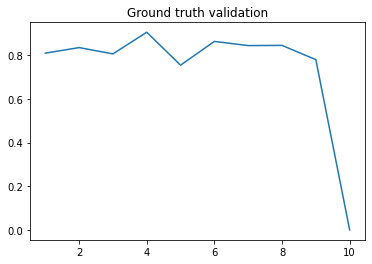

In [64]:
df_plot = df_training#.query('bo_iteration>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['bo_iteration']
y = df_plot['loss']

plt.plot(x, y)
plt.title('Ground truth validation')
plt.show()

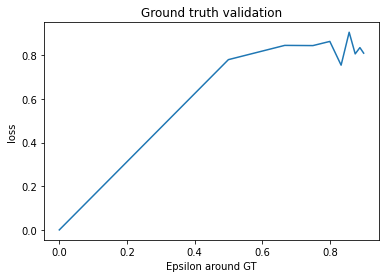

In [69]:
df_plot = df_training#.query('bo_iteration>0')
import numpy as np
import matplotlib.pyplot as plt

y = df_plot['loss']
x = df_plot['epsilon_around_gt']

plt.plot(x, y)
plt.title('Ground truth validation')
plt.xlabel('Epsilon around GT')
plt.ylabel('loss')
plt.show()

In [16]:
df_training.to_csv(f"./data/{simulation_setup}_trust_region_BO.csv", index = None)